# Visualizing FastText Model

This notebook develops functions for visualizing semantic relationships preserved in a FastText model of the Sumerian corpus using t-SNE and Bokeh.

Inspired by [*LDA visualized using t-SNE and Bokeh*](https://www.kaggle.com/yohanb/lda-visualized-using-t-sne-and-bokeh) by Yohan, and [*Visualizing Word Vectors with t-SNE*](https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne) by Jeff Delayney.

Note: for visualization Bokeh is preferred over Matplotlib primarily because of the difficulties in using a custom font in Matplotlib. This becomes a major obstacle when trying to represent tokens in cuneiform.

In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
warnings.filterwarnings(action='ignore', category=FutureWarning, module='gensim' )
import gensim
import numpy as np
import pickle
from sklearn.manifold import TSNE
from gensim.models.fasttext import FastText as FT_gensim
import pandas as pd
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import ColumnDataSource, LabelSet, Legend, LegendItem, Range1d #, HoverTool, CustomJS, , Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
from bokeh.palettes import Category20
output_notebook()
# note: more recent bokeh versions require notebook 5 or JupyterLab

Loading BokehJS ...

# Load the Models
There are three models: 
- model_cuneiform.model: the Sumerian copus in Unicode cuneiform
- model_tl.model: the Sumerian corpus in transliteration
- model_lemm.model: the Sumerian corpus in lemmatization

In [2]:
model_c = FT_gensim.load("model/model_cuneiform.model")
model_l = FT_gensim.load("model/model_lemm.model")
model_t = FT_gensim.load("model/model_tl.model")

# Cuneify
Create a function that allows input in transliteration, with output in cuneiform.

In [4]:
with open("output/ogsl.p", "rb") as p:
    o = pd.read_pickle(p, compression = None)
signs_d = dict(zip(o["value"], o["utf8"]))

In [5]:
def cun(text): 
    """transform transliterated input into cuneiform. Use unicode subscript numbers and separate all signs with hyphens; separate words with blanks
    Examples: 'ma-an-gi₄'; 'd-en-lil₂ nibru-ki'.
    Transliteration style (sugal₇ vs. sukkal; dug₄ vs. du₁₁; gen vs. ŋen; etc.) and capitalization are unimportant.
    """
    cun_line = []
    words = text.lower().split()
    for word in words: 
        signs = word.lower().split('-')
        seq = [signs_d[s] if s in signs_d else s for s in signs]
        seq = ''.join(seq)
        cun_line.append(seq)
    line = ' '.join(cun_line)
    return(line)

# Create Lists of Semantically Related Words

In [6]:
def word_categories(model, words, topn=10):
    """word_categories takes an iterable with one or more words from the vocabulary of model.
    For each word a dictionary of similar words (with the target word) is construed.
    The value of each word is numerical (integer) and indicates the category to which it belongs.
    The function returns a dictionary."""
    word_d = {}
    for idx, word in enumerate(words):
        w = model.wv.most_similar(word, topn=topn)
        w = [m[0] for m in w]
        w.append(word)
        for item in w:
            if item in word_d:
                word_d[item] = len(words)
            else:
                word_d[item] = idx
    return word_d

# Project and Visualize Related Words

In [7]:
def tsne_bokeh(model, word_d, words, fontsize="12pt"):

    labels = []
    tokens = []
    categories = []
    legend = []
    
    for word in word_d:
        tokens.append(model.wv[word])
        labels.append(word)
        categories.append(word_d[word])
        if word_d[word] == len(words): 
            legend.append("mixed")
        else: 
            legend.append(words[word_d[word]])
    
    color_d = {0: "black", 1: "red", 2: "green", 3: "yellow", 4: "brown", 5: "blue"}
    colors = [color_d[category] for category in categories]
    #c = Category20[len(words) + 1]
    #colors = [c[category] for category in categories]
    
    tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    tsne_embedding = tsne.fit_transform(tokens)
    tsne_embedding = pd.DataFrame(tsne_embedding, columns=['x','y'])
    tsne_embedding["color"] = colors
    tsne_embedding["labels"] = labels
    tsne_embedding["legend"] = legend

    source = ColumnDataSource(
        data=dict(
        x = tsne_embedding.x,
        y = tsne_embedding.y,
        colors = tsne_embedding.color,
        labels=tsne_embedding.labels,
        legend = tsne_embedding.legend
        )
    )

    l = LabelSet(x='x', y='y', text='labels', level='glyph',
              x_offset=5, y_offset=5, source=source, render_mode='canvas', 
             text_font_size=fontsize, text_font="CuneiformComposite")

    plot_tsne = figure(plot_width=900, plot_height=900) #, tools=tools_tsne, title='Papers')
    plot_tsne.circle('x', 'y', size=7, fill_color='colors', 
                  line_alpha=0, line_width=0.01, source=source, legend="legend")
    plot_tsne.add_layout(l)
    plot_tsne.legend.border_line_width = 3
    plot_tsne.legend.border_line_color = "black"
    plot_tsne.legend.border_line_alpha = 1
    plot_tsne.legend.location = "top_right"
    plot_tsne.legend.background_fill_color = "beige"
    plot_tsne.legend.background_fill_alpha = 0.5
    return plot_tsne

In [12]:
#output_file("graphs/vegetables_perfumes.html")
vegetables_perfumes = ["šim-gig", "hi{sar}"]
words_d = word_categories(model_l, vegetables_perfumes, 35)
p2 = tsne_bokeh(model_l, words_d, vegetables_perfumes, "12pt")
#save(p2)
show(p2)

In [13]:
central_bureau = [cun("na-sa₆"), cun("ab-ba-sa₆-ga"), cun("in-ta-e₃-a")]
c_b = word_categories(model_c, central_bureau, 20)
p1 = tsne_bokeh(model_c, c_b, central_bureau, "20pt")
save(p1)
show(p1)

RuntimeError: Models must be owned by only a single document, LinearAxis(id='1674', ...) is already in a doc

In [ ]:
output_file("graphs/vegetables_perfumes_l.html")
vegetables_perfumes = ["šimgig[tree]N", "hiz[vegetable]N"]
words_d = word_categories(model_l, vegetables_perfumes, 35)
p2 = tsne_bokeh(model_l, words_d, vegetables_perfumes, "12pt")
save(p2)
show(p2)

In [14]:
model_c.wv.most_similar(cun("ab-ba-sa₆-ga"), topn = 20)

[('𒉌𒆪', 0.932532548904419),
 ('𒇽𒀭𒊏', 0.9131841659545898),
 ('𒌨𒀭𒁹𒀭', 0.9126472473144531),
 ('𒌨𒀭𒍂𒇽𒄭', 0.912060022354126),
 ('𒈾𒊷', 0.9108825922012329),
 ('𒌨𒈩', 0.9093538522720337),
 ('𒀭𒇷𒉌', 0.9093157052993774),
 ('𒁀𒀭𒍣', 0.9069061279296875),
 ('𒇽𒀭𒋫', 0.905991792678833),
 ('𒌨𒀭𒊩𒌆𒂯', 0.9053531289100647),
 ('𒌨𒀭𒀭𒁹𒀭', 0.9049001932144165),
 ('𒌨𒌉', 0.9048447012901306),
 ('𒌨𒀭𒂗𒃲𒁺𒁺', 0.9034087061882019),
 ('𒌨𒀭𒀹𒀭', 0.9028141498565674),
 ('𒁕𒆷𒀀', 0.9024139046669006),
 ('𒌨𒊷𒂵', 0.9018524885177612),
 ('𒌨𒀭𒅎', 0.9017372131347656),
 ('𒇽𒀭𒋀𒆠', 0.9016849994659424),
 ('𒌨𒄯', 0.901616096496582),
 ('𒁀𒂵𒀀', 0.9013009071350098)]

In [15]:
naramili = cun("na-ra-am-i₃-li₂")

In [16]:
model_c.wv.most_similar(naramili)

[('𒋗𒆏𒁕', 0.9129835367202759),
 ('𒋗𒀭𒅘𒋫', 0.9104877710342407),
 ('𒋗𒀭𒆏𒁕', 0.873989462852478),
 ('𒉌𒃮𒅗', 0.8698017597198486),
 ('𒀀𒍪', 0.8612921833992004),
 ('𒈨𒀭𒅗𒁲', 0.8588619232177734),
 ('𒀀𒉈𒀀', 0.8588420152664185),
 ('𒂍𒀀𒊬', 0.853057861328125),
 ('𒋗𒆏𒋫', 0.8526027202606201),
 ('𒈾𒉿𒅕𒀭', 0.8515530824661255)]

In [17]:
model_c.wv.most_similar(cun("lugal-iti-da"))

[('𒌺𒉌', 0.9661909937858582),
 ('𒄊𒉌', 0.9650068283081055),
 ('𒌨𒈗', 0.9649462699890137),
 ('𒅗𒀭𒇋', 0.9646690487861633),
 ('𒈗𒅗', 0.9633299708366394),
 ('𒁀𒊷', 0.9598506689071655),
 ('𒀀𒀀𒄀𒈾', 0.95875084400177),
 ('𒂇𒀭𒉌', 0.9579757452011108),
 ('𒌨𒄖', 0.9578690528869629),
 ('𒌨𒀭𒌉𒍣𒁕', 0.9577254056930542)]

In [18]:
babati_abbasaga = [cun("ba-ba-ti"), cun("ab-ba-sa₆-ga")]
words_d = word_categories(model_c, babati_abbasaga, 10)
p2 = tsne_bokeh(model_c, words_d, babati_abbasaga, "20pt")
show(p2)

RuntimeError: Models must be owned by only a single document, LinearAxis(id='1674', ...) is already in a doc

In [ ]:
p_d = ["ab-ba-sa₆-ga", "u₂-ta₂-mi-šar-ra-am", "a-hu-we-er", "tu-ra-am-d-da-gan"]

In [19]:
p_d = ["šu-{d}idim", "šu-kab-ta", "šu-{d}kab₂-ta₂", "šu-{d}kab-ta₂"]

In [20]:
for item in p_d: 
    print(item in model_t.wv.vocab)

True
True
False
True


In [21]:
pd = [model_c.wv[p] for p in p_d]

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [23]:
Z = linkage(pd, 'ward')

In [24]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [25]:
c, coph_dists = cophenet(Z, pdist(pd))
c

0.9928570244753727

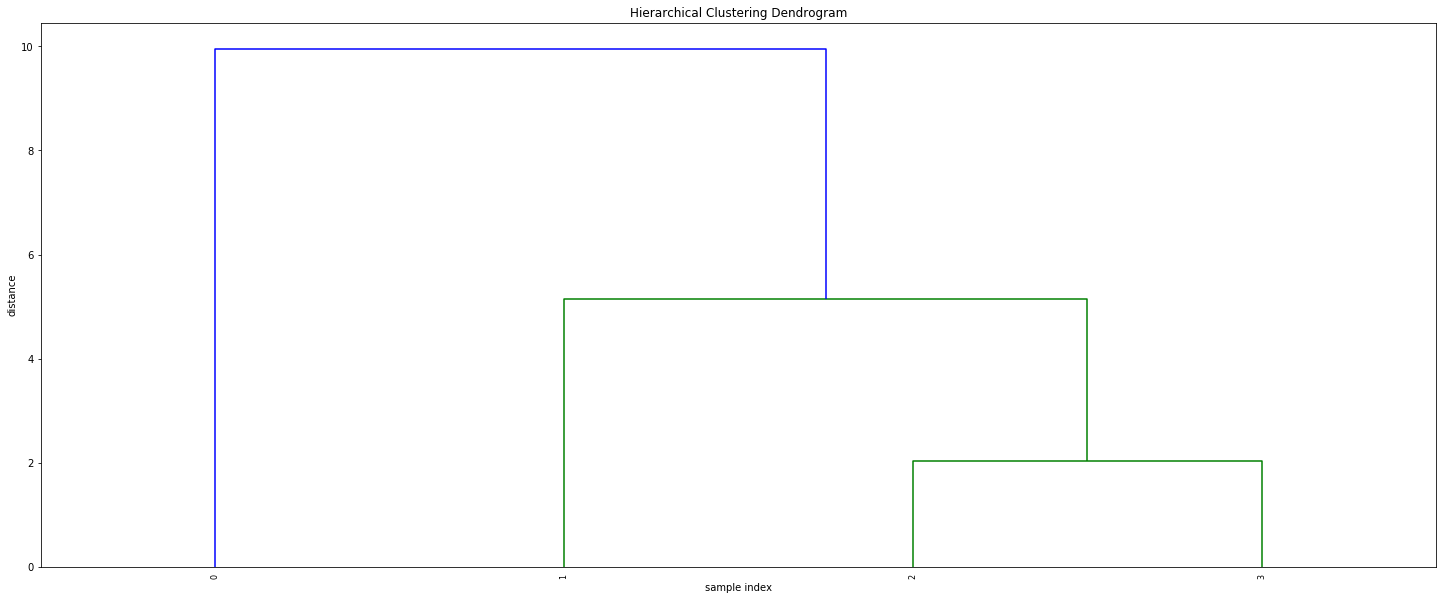

In [26]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [27]:
def dendro(model, word, topn=10): 
    words = model.wv.most_similar(word, topn = topn)
    words = [w[0] for w in words]
    words.append(word)
    vectors = [model.wv[p] for p in words]
    l = linkage(vectors, method='complete', metric='seuclidean')

# calculate full dendrogram
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.ylabel('word')
    plt.xlabel('distance')

    dendrogram(
        l,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
        leaf_label_func=lambda v: str(words[v])
        )
    plt.show()

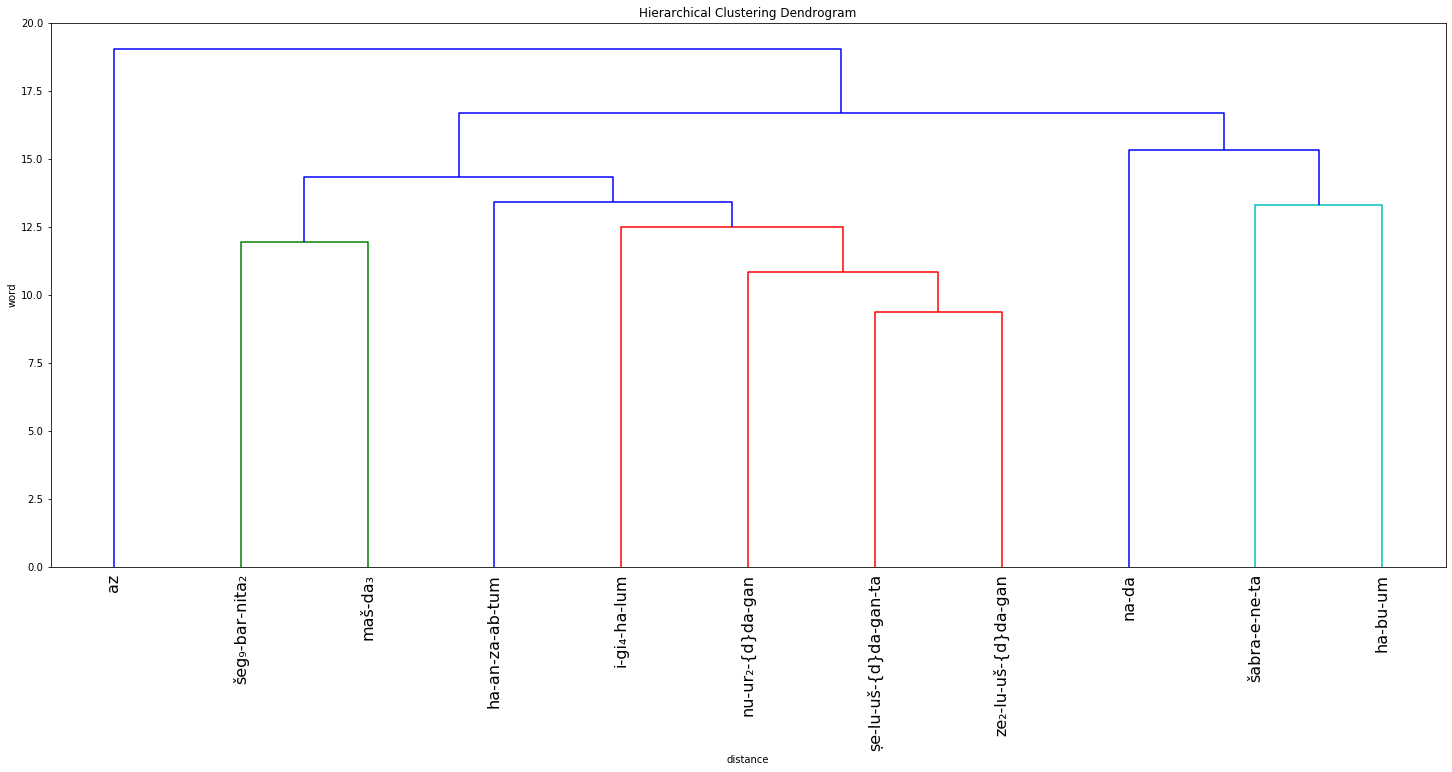

In [28]:
dendro(model_t, "ha-bu-um")

In [29]:
model_c.wv.most_similar(positive=["𒊺", "𒆬𒄀"], negative=["𒃻"])

[('𒄭𒄊𒀀', 0.943866491317749),
 ('𒋛𒁲', 0.9368213415145874),
 ('𒃻𒉿', 0.9308702945709229),
 ('𒀀𒁉𒍝', 0.9291903376579285),
 ('𒆬𒌓', 0.9288144111633301),
 ('𒐈𒅅', 0.9267836809158325),
 ('𒋗𒄥', 0.9232182502746582),
 ('𒌈𒁾', 0.9228167533874512),
 ('𒍝𒄵', 0.9221596717834473),
 ('𒄭𒁕', 0.9183016419410706)]

In [ ]:
nakabtum_a = [cun("a-hu-ni"), cun("d-šul-gi-a-a-mu"), cun("šu-ma-ma"), cun("zu-ba-ga")]

In [ ]:
for name in directors: 
    print(name in model_c.wv.vocab)

In [ ]:
nakabtum_b = [cun("lu₂-dingir-ra"), cun("a-hu-we-er"), cun("igi-d-en-lil₂-še₃")]

In [ ]:
royal_court = [cun("u₂-ta₂-mi-šar-ra-am"), cun("tu-ra-am-d-da-gan"), cun("tah-ša-tal")]

In [ ]:
tummal = [cun("en-dingir-mu")]

In [ ]:
enlila = [cun("d-en-lil₂-la₂")]

In [ ]:
urkununa = [cun("ur-kug-nun-na")]

In [ ]:
nalu = [cun("na-lu₅")]

In [ ]:
central = [cun("ab-ba-sa₆-ga"), cun("in-ta-e₃-a"), cun("na-sa₆")]

In [ ]:
directors = [cun("na-ra-am-i₃-li₂"), cun("lugal-iti-da"), cun("d-šara₂-kam")]

In [ ]:
offices = [nakabtum_a, nakabtum_b, enlila, nalu, 
           urkununa, central, directors]
office_names = ["Nakabtum A", "Nakabtum B", "Enlila", "Nalu", "Urkununa", "Central Bureau", "Directors"]
p = figure(plot_width=900, plot_height=900) 

In [ ]:
tokens = []
labels = []
categories = []
legend = []
for idx, office in enumerate(offices): 
    for name in office: 
        tokens.append(model_c.wv[name])
        labels.append(name)
        categories.append(idx)
        legend.append(office_names[idx])

In [ ]:
from bokeh.palettes import Category20
c = all_palettes["Spectral"][len(offices)]
colors = [c[category] for category in categories]

In [ ]:
tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_embedding = tsne.fit_transform(tokens)
tsne_embedding = pd.DataFrame(tsne_embedding, columns=['x','y'])
tsne_embedding["color"] = colors
tsne_embedding["labels"] = labels
tsne_embedding["legend"] = legend

In [ ]:
source = ColumnDataSource(
        data=dict(
        x = tsne_embedding.x,
        y = tsne_embedding.y,
        colors = tsne_embedding.color,
        labels=tsne_embedding.labels,
        legend = tsne_embedding.legend
        )
    )

In [ ]:
l = LabelSet(x='x', y='y', text='labels', level='glyph',
              x_offset=5, y_offset=5, source=source, render_mode='canvas', 
             text_font_size="20pt", text_font="CuneiformComposite")

plot_tsne = figure(plot_width=900, plot_height=900) #, tools=tools_tsne, title='Papers')
plot_tsne.circle('x', 'y', size=7, fill_color='colors', 
                  line_alpha=0, line_width=0.01, source=source, legend="legend")
plot_tsne.add_layout(l)
plot_tsne.legend.border_line_width = 3
plot_tsne.legend.border_line_color = "black"
plot_tsne.legend.border_line_alpha = 1
plot_tsne.legend.location = "top_left"
plot_tsne.legend.background_fill_color = "beige"
plot_tsne.legend.background_fill_alpha = 0.5

In [ ]:
show(plot_tsne)

In [ ]:
all_palettes["Spectral"][6]

In [ ]:
with open("output/utf8_lemm_d.p", 'rb') as f: 
    utf8_lemm = pickle.load(f)
utf8_lemm

In [ ]:
utf8_lemm[cun("za-bir")]

In [ ]:
nakabtum_a

In [ ]:
wild_animals = [cun("ur-mah"), cun("muš"), cun("az"), cun("ka₅-a"), cun("šeg₉"), cun("maš-da₃"), cun("šeg₉-bar"), 
                cun("dara₄"), cun("am"), cun("am-si"), cun("am-si-kur-ra")]

In [ ]:
domestic_animals = [cun("udu"), cun("gud"), cun("u₈"), cun("ab₂"), cun("anše"), cun("eme₅"), cun("sila₄"), cun("kir₁₁"), cun("amar"), 
                  cun("uz₃"), cun("maš₂") ]

In [ ]:
animals = wild_animals.copy()
animals.extend(domestic_animals)

In [ ]:
animal_like = model_c.wv.most_similar(animals, topn=20)
animal_like = [word for word, similarity in animal_like]

In [ ]:
animals.extend(animal_like)

In [ ]:
x = [model_c.wv.similarity(cun("ur-mah"), word) for word in animals]
y = [model_c.wv.similarity(cun("udu"), word) for word in animals]

In [ ]:
df = pd.DataFrame({"x" : x, "y": y, "labels" : animals})

In [ ]:
source = ColumnDataSource(
        data=dict(
        x = df.x,
        y = df.y,
        labels=df.labels,
        )
    )

In [ ]:
lab = LabelSet(x='x', y='y', text='labels', level='glyph',
              x_offset=5, y_offset=5, source=source, render_mode='canvas', 
             text_font_size="15pt", text_font="CuneiformComposite")
p3 = figure(plot_width=900, plot_height=900) #, tools=tools_tsne, title='Papers')
p3.circle('x', 'y', size=7, fill_color='red', 
                  line_alpha=0, line_width=0.01, source=source)
left, right, bottom, top = .8, 1.01, .8, 1.01
p3.x_range=Range1d(left, right)
p3.y_range=Range1d(bottom, top)
p3.add_layout(lab)
p3.line([0, 1], [0, 1], line_width=2)

In [ ]:
show(p3)

In [ ]:
model_c

In [ ]:
model_c.wv[cun("lugal")]